# SSP-MMC for FSRS

SSP-MMC stands for "Stochastic-Shortest-Path-Minimize-Memorization-Cost". It is a reinforcement learning algorithm that is designed to minimize the cost of memorization in the context of spaced repetition. This is a re-implementation of the original SSP-MMC algorithm in Numpy. The memory model is updated to FSRS instead of DHP-HLR.

Original code: https://github.com/maimemo/SSP-MMC

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

s_size = 10000
s_min = 0.5
s_max = 3650

d_size = 90
d_min = 1
d_max = 10

r_size = 30
r_min = 0.69
r_max = 0.96

s_state = np.linspace(s_min, s_max, s_size)
d_state = np.linspace(d_min, d_max, d_size)
r_state = np.linspace(r_min, r_max, r_size)

s_state_mesh, d_state_mesh, r_state_mesh = np.meshgrid(
    s_state, d_state, r_state)

DECAY = -0.5
FACTOR = 0.9 ** (1.0 / DECAY) - 1.0

def power_forgetting_curve(t, s):
    return (1 + FACTOR * t / s) ** DECAY

def next_interval(s, r):
    ivl = s / FACTOR * (r ** (1.0 / DECAY) - 1.0)
    return np.maximum(1, np.floor(ivl))

ivl_mesh = next_interval(s_state_mesh, r_state_mesh)
r_state_mesh = power_forgetting_curve(ivl_mesh, s_state_mesh)

cost_matrix = np.zeros((d_size, s_size))
cost_matrix.fill(1000)
cost_matrix[:, -1] = 0
action_matrix = np.zeros((d_size, s_size))

w = [
    0.5701, 1.4436, 4.1386, 10.9355,
    5.1377, 1.225, 0.8735, 0.0375,
    1.647, 0.1361, 1.0293,
    2.1111, 0.0864, 0.323, 1.4188,
    0.219, 2.8467
]


def stability_after_success(s, d, r):
    return np.maximum(
        s_min,
        s
        * (
            1
            + np.exp(w[8])
            * (11 - d)
            * np.power(s, -w[9])
            * (np.exp((1 - r) * w[10]) - 1)
        ),
    )


def stability_after_failure(s, d, r):
    return np.maximum(
        s_min,
        np.minimum(
            w[11]
            * np.power(d, -w[12])
            * (np.power(s + 1, w[13]) - 1)
            * np.exp((1 - r) * w[14]),
            s,
        ),
    )


def mean_reversion(init, current):
    return (w[7] * init + (1 - w[7]) * current).clip(1, 10)


def difficulty_after_success(d):
    return mean_reversion(w[4], d)


def difficulty_after_failure(d):
    return mean_reversion(w[4], d + 2 * w[6])


# stability to index
def s2i(s): return np.clip(np.floor((s - s_min) /
                                    (s_max - s_min) * s_size).astype(int), 0, s_size - 1)


# difficulty to index
def d2i(d): return np.clip(np.floor((d - d_min) /
                                    (d_max - d_min) * d_size).astype(int), 0, d_size - 1)


# retention to index
def r2i(r): return np.clip(np.floor((r - r_min) /
                                    (r_max - r_min) * r_size).astype(int), 0, r_size - 1)


# indexes to cost
def i2c(s, d): return cost_matrix[d2i(d), np.maximum(
    s2i(s), s2i(s_state_mesh) + 1).clip(0, s_size - 1)]

In [2]:
i = 0
diff = 10000
n_iter = 1000

success_cost = 3
failure_cost = 9

start = time.time()

while i < n_iter and diff > 1e-6 * s_size * d_size:
    next_stability_after_success = stability_after_success(
        s_state_mesh, d_state_mesh, r_state_mesh
    )
    next_difficulty_after_success = difficulty_after_success(d_state_mesh)
    next_cost_after_success = (
        i2c(next_stability_after_success,
            next_difficulty_after_success) + success_cost
    )

    next_stability_after_failure = stability_after_failure(
        s_state_mesh, d_state_mesh, r_state_mesh
    )
    next_difficulty_after_failure = difficulty_after_failure(d_state_mesh)
    next_cost_after_failure = (
        i2c(next_stability_after_failure,
            next_difficulty_after_failure) + failure_cost
    )

    expected_cost = (
        r_state_mesh * next_cost_after_success
        + (1 - r_state_mesh) * next_cost_after_failure
    )
    # update cost matrix
    optimal_cost = np.minimum(cost_matrix, expected_cost.min(axis=2))
    retention_matrix = r_state[np.argmin(expected_cost, axis=2)]
    diff = cost_matrix.sum() - optimal_cost.sum()
    cost_matrix = optimal_cost
    if i % 10 == 0:
        print(
            f"iteration {i:>5}, diff {diff:.2f}, time {time.time() - start:.2f}s")
    i += 1

end = time.time()
print(f"Time: {end - start:.2f}s")
avg_cost = cost_matrix.mean()
print(f"Average cost: {avg_cost:.2f}")
avg_retention = retention_matrix.mean()
print(f"Average retention: {avg_retention:.2f}")

iteration     0, diff 620891463.83, time 2.82s
iteration    10, diff 1004475.30, time 33.25s
iteration    20, diff 3635.86, time 61.42s
iteration    30, diff 1.27, time 89.72s
Time: 92.76s
Average cost: 6.67
Average retention: 0.88


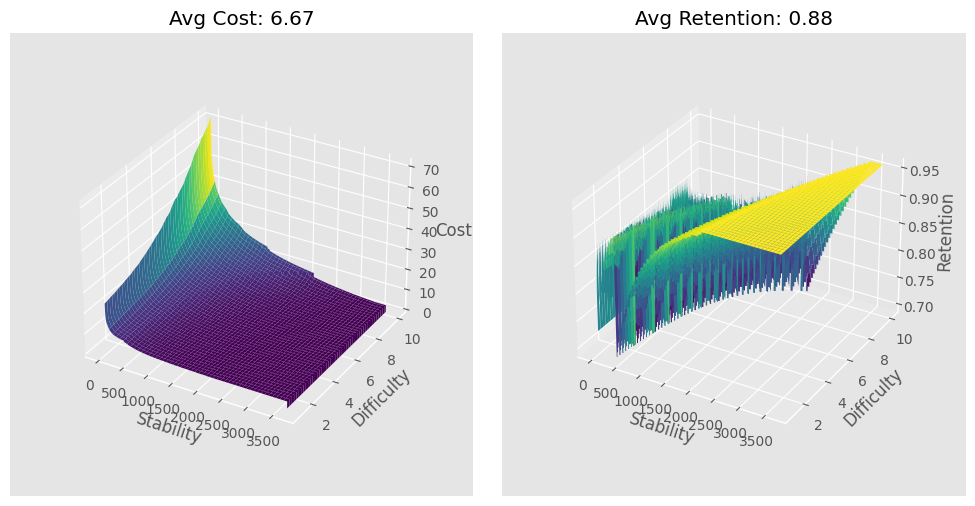

In [3]:
s_state_mesh_2d, d_state_mesh_2d = np.meshgrid(s_state, d_state)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection="3d")
ax.plot_surface(s_state_mesh_2d, d_state_mesh_2d, cost_matrix, cmap="viridis")
ax.set_xlabel("Stability")
ax.set_ylabel("Difficulty")
ax.set_zlabel("Cost")
ax.set_title(f"Avg Cost: {avg_cost:.2f}")
ax.set_box_aspect(None, zoom=0.8)
ax = fig.add_subplot(122, projection="3d")
ax.plot_surface(s_state_mesh_2d, d_state_mesh_2d, retention_matrix, cmap="viridis")
ax.set_xlabel("Stability")
ax.set_ylabel("Difficulty")
ax.set_zlabel("Retention")
ax.set_title(f"Avg Retention: {avg_retention:.2f}")
ax.set_box_aspect(None, zoom=0.8)
plt.tight_layout()
plt.show()

Retention: 69.00%
Time: 3.68s, Iterations: 34


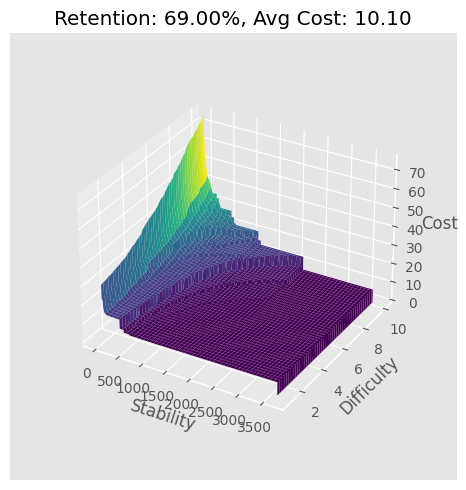

Retention: 72.00%
Time: 3.26s, Iterations: 33


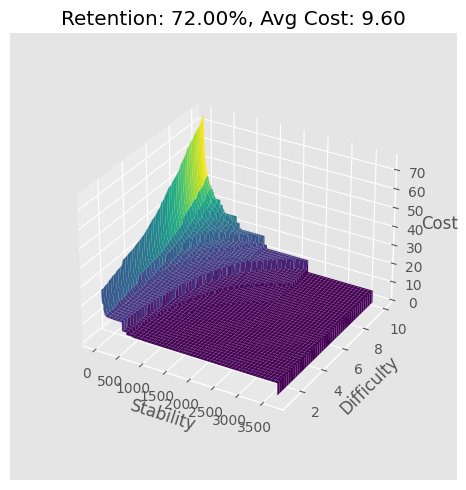

Retention: 75.00%
Time: 3.25s, Iterations: 33


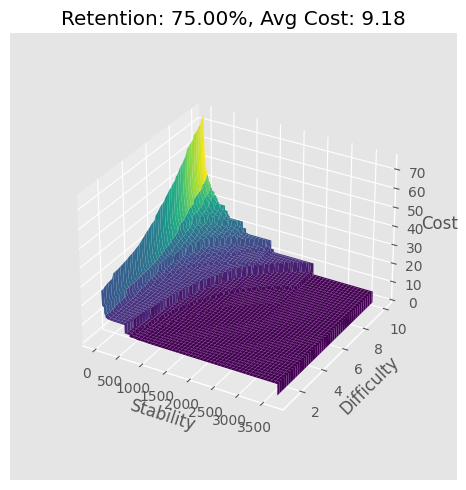

Retention: 78.00%
Time: 3.29s, Iterations: 33


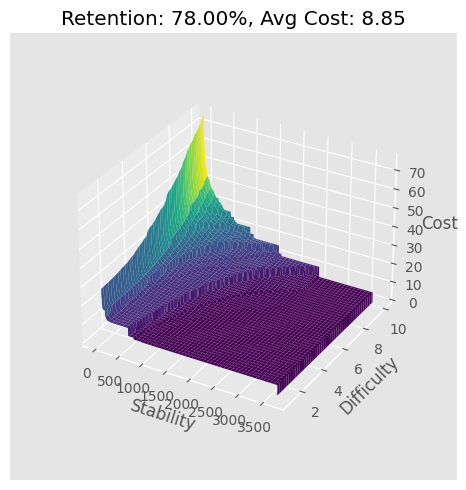

Retention: 81.00%
Time: 3.53s, Iterations: 34


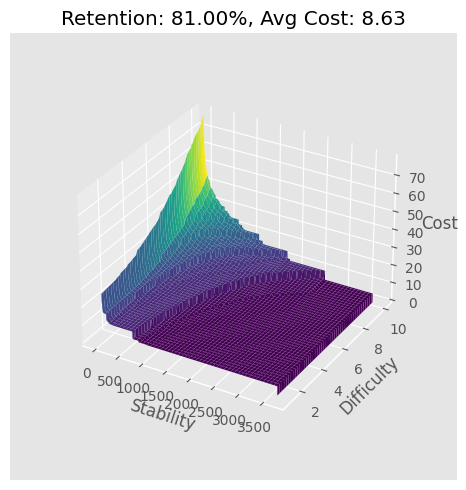

Retention: 84.00%
Time: 3.81s, Iterations: 35


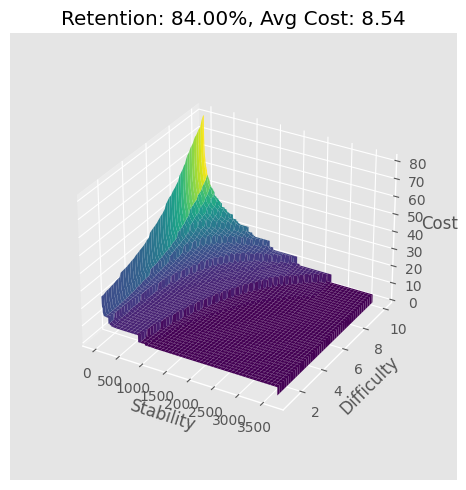

Retention: 87.00%
Time: 4.26s, Iterations: 38


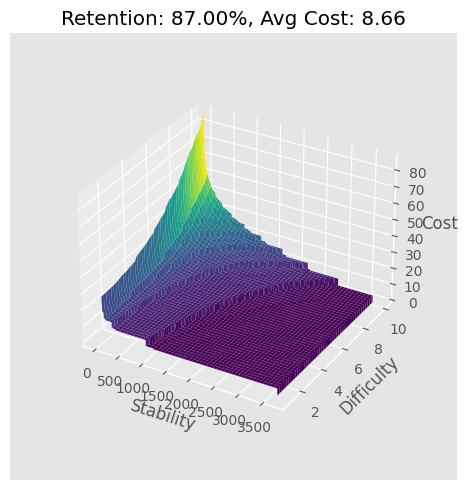

Retention: 90.00%
Time: 4.07s, Iterations: 43


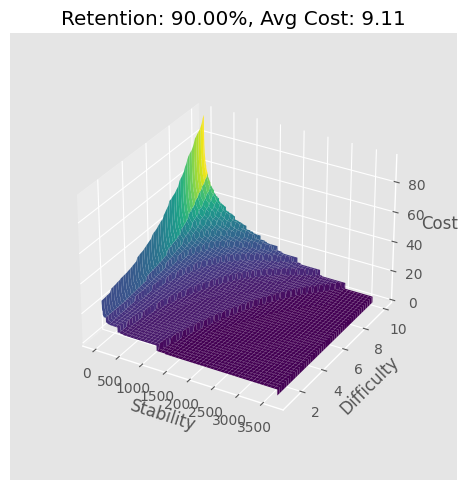

Retention: 93.00%
Time: 5.25s, Iterations: 51


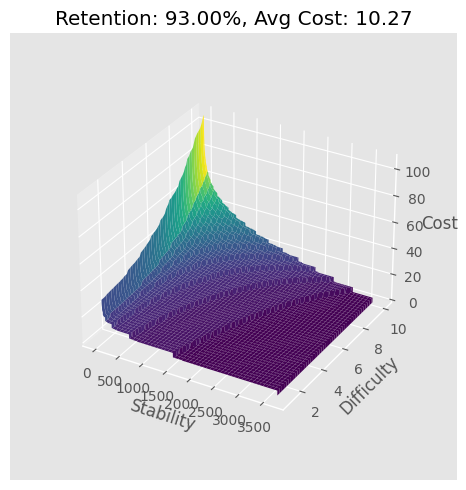

Retention: 96.00%
Time: 6.89s, Iterations: 70


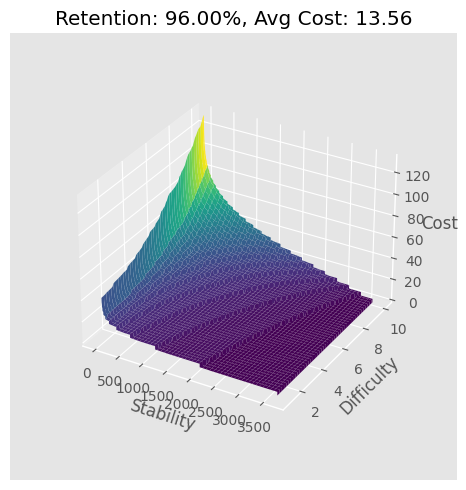

In [4]:
success_cost = 3
failure_cost = 9

costs = []

r_range = np.linspace(r_min, r_max, 10)

for r in r_range:
    start = time.time()
    print(f"Retention: {r * 100:.2f}%")
    cost_matrix = np.zeros((d_size, s_size))
    cost_matrix.fill(1000)
    cost_matrix[:, -1] = 0
    s_state_mesh, d_state_mesh = np.meshgrid(s_state, d_state)
    r_state_mesh = r * np.ones((d_size, s_size))
    ivl_mesh = next_interval(s_state_mesh, r_state_mesh)
    r_state_mesh = power_forgetting_curve(ivl_mesh, s_state_mesh)

    i = 0
    diff = 10000
    n_iter = 1000
    while i < n_iter and diff > 1e-6 * s_size * d_size:
        next_stability_after_success = stability_after_success(
            s_state_mesh, d_state_mesh, r_state_mesh
        )
        next_difficulty_after_success = difficulty_after_success(d_state_mesh)
        next_cost_after_success = (
            i2c(next_stability_after_success, next_difficulty_after_success)
            + success_cost
        )

        next_stability_after_failure = stability_after_failure(
            s_state_mesh, d_state_mesh, r_state_mesh
        )
        next_difficulty_after_failure = difficulty_after_failure(d_state_mesh)
        next_cost_after_failure = (
            i2c(next_stability_after_failure, next_difficulty_after_failure)
            + failure_cost
        )

        expected_cost = (
            r_state_mesh * next_cost_after_success
            + (1 - r_state_mesh) * next_cost_after_failure
        )
        # update cost matrix
        optimal_cost = np.minimum(cost_matrix, expected_cost)
        diff = cost_matrix.sum() - optimal_cost.sum()
        cost_matrix = optimal_cost
        i += 1
    end = time.time()
    print(f"Time: {end - start:.2f}s, Iterations: {i}")
    avg_cost = cost_matrix.mean()
    costs.append(avg_cost)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(s_state_mesh, d_state_mesh, cost_matrix, cmap="viridis")
    ax.set_xlabel("Stability")
    ax.set_ylabel("Difficulty")
    ax.set_zlabel("Cost")
    ax.set_title(f"Retention: {r * 100:.2f}%, Avg Cost: {avg_cost:.2f}")
    ax.set_box_aspect(None, zoom=0.8)
    plt.tight_layout()
    plt.show()

Text(0.5, 1.0, 'Optimal Retention: 84.00%')

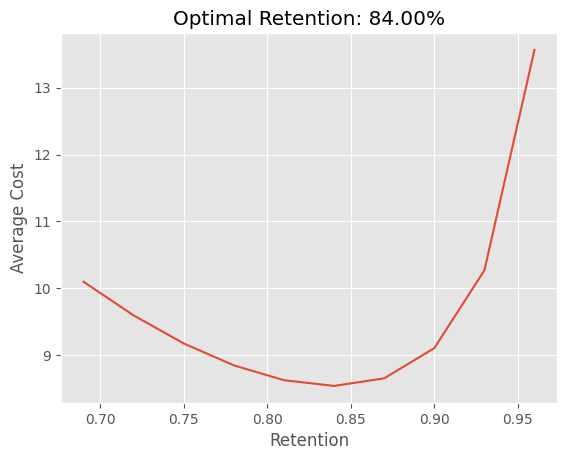

In [5]:
optimal_retention = r_range[np.argmin(costs)]
plt.plot(r_range, costs)
plt.xlabel("Retention")
plt.ylabel("Average Cost")
plt.title(f"Optimal Retention: {optimal_retention * 100:.2f}%")